In [ ]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"


MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME


# Engine

## MLC-LLM

In [9]:
METHOD = "engine/mlcllm"
METHOD_EXPORTS = EXPORTS / METHOD

In [10]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: ..
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/mlcllm


In [25]:
# EXL2 quant sizes
mlcllm_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_dir()]
mlcllm_models.append(MODEL_PATH)

for model in mlcllm_models:

    # model_size := size of output.safetensors or <model>.bin
    model_size = sum([x.stat().st_size for x in model.glob("*.bin")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

q4f16_1: 3.53 GiB
q4f16_autoawq_gemm: 3.62 GiB
q0f16: 12.55 GiB
q3f16_1: 2.84 GiB
Llama-2-7b-hf: 12.55 GiB


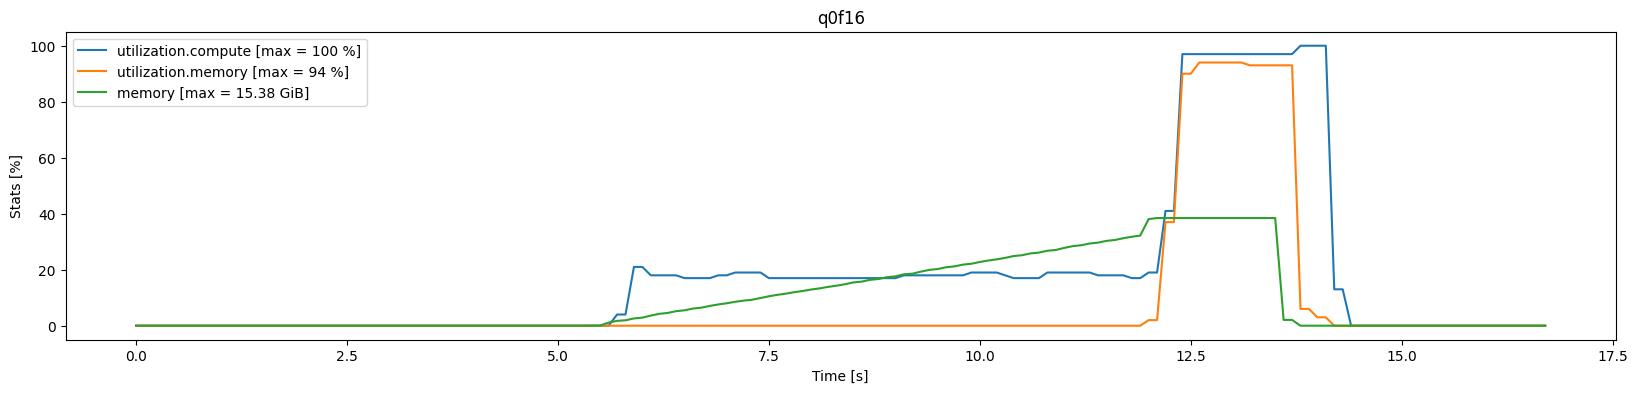

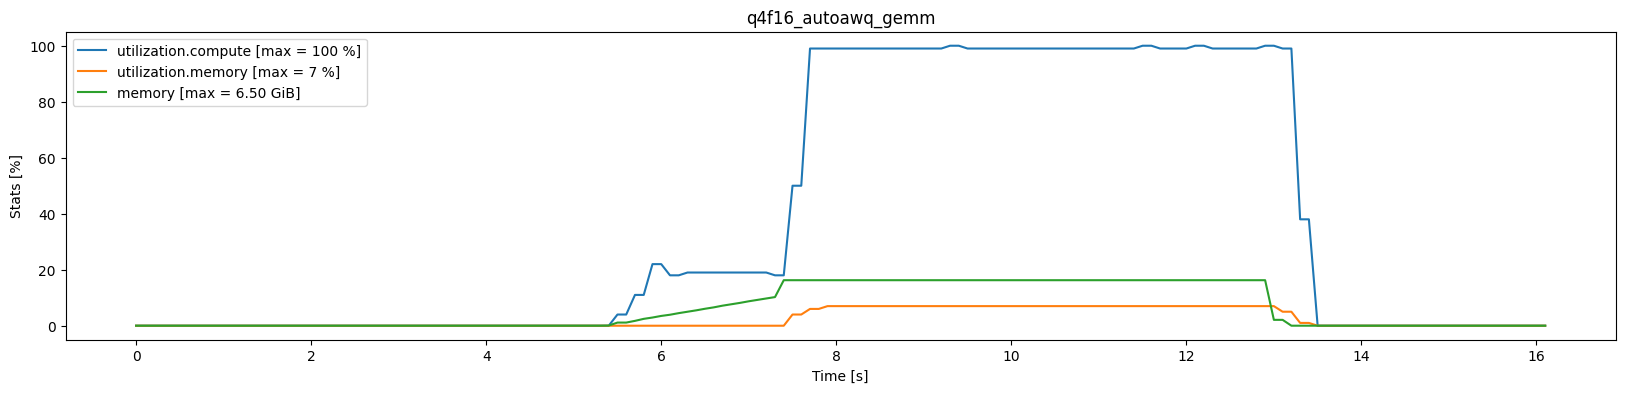

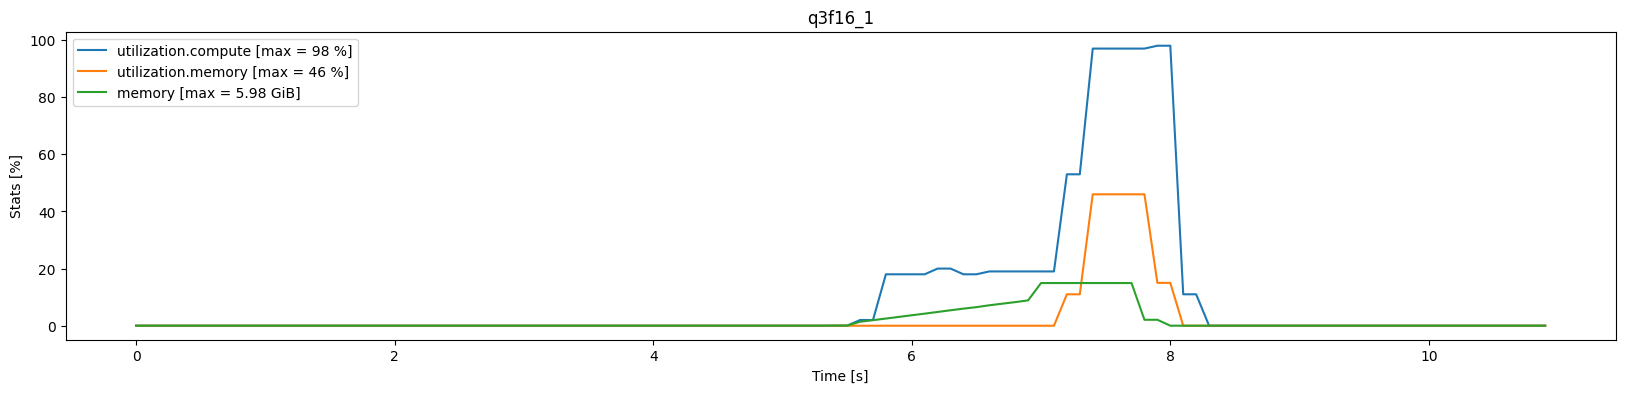

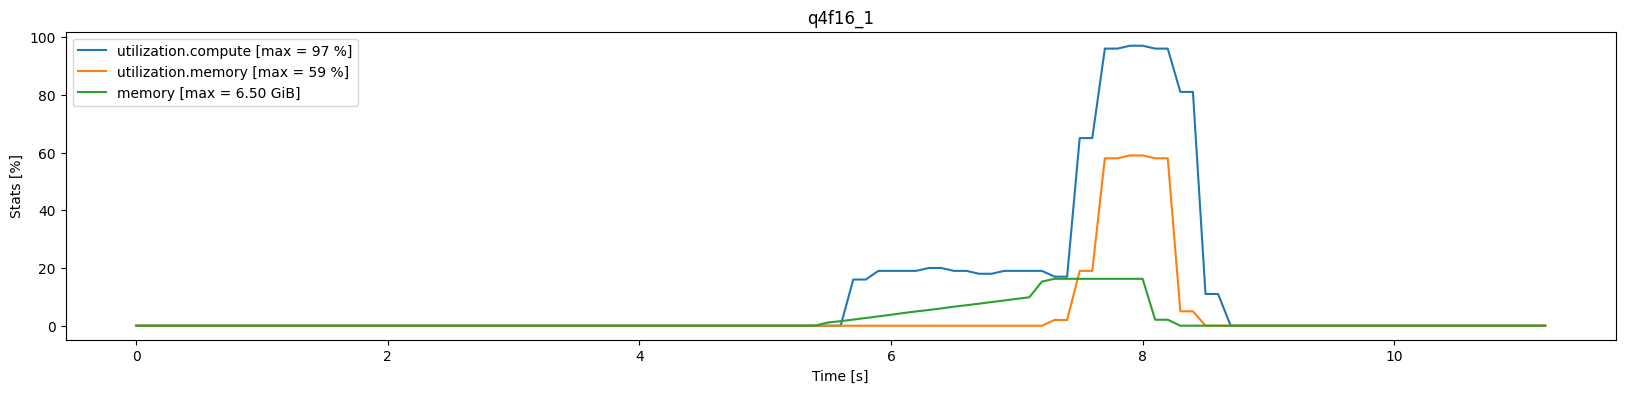

In [39]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)

    # if "squeeze" in csv.name:
    #     df = df[df.index % 10 == 0]

    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][:-4].strip("_"))
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")

In [38]:
# benchmark logs
all_logs = list(METHOD_EXPORTS.glob("*.log"))

for log in all_logs:
    if not "bench" in log.name:
        continue
    print(f"{log.name.replace('_', ' ')[:-4]}")
    with open(log) as f:
        lines = f.readlines()
    print("".join(lines[-4:]), end="")

bench q4f16 1
throughput: 189.074 tok/s
total tokens: 128 tok
total time: 0.677 s

bench q4f16 autoawq gemm
throughput: 23.626 tok/s
total tokens: 128 tok
total time: 5.418 s

bench q3f16 1
throughput: 185.471 tok/s
total tokens: 128 tok
total time: 0.690 s

bench q0f16
throughput: 87.371 tok/s
total tokens: 128 tok
total time: 1.465 s

